# Fisher Exact test for m6A peak/nonpeak and RBP binding sites
#### Use merged/unmerged m6A peak and unmerged nonpeak, obtain their intersections with RBP binding sites respectively.
#### Perform Fisher's exact test for each RBP: 
(1) the number of intersection with m6A peaks

(2) the total number of intersection with peaks minus (1)

(3) the number of intersection with nonpeaks

(4) the total number of intersection with nonpeaks minus (3)
#### Check the test statistics for potential m6A binding proteins (YTHDF, HNRNP, FMRP, IGF2BP, G3BP)
There are no RBPs that contains keywords "YTHDF" or "G3BP". Only "HNRNP", "FMR1" and "IGF2BP" are found, including 'IGF2BP3', 'HNRNPUL1', 'HNRNPA1', 'HNRNPM', 'IGF2BP1', "FMR1", 'HNRNPK', 'HNRNPU', 'IGF2BP2', 'HNRNPC'.

In [86]:
import pandas as pd, numpy as np
from pybedtools import BedTool
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from fisher import pvalue
import os
path = os.path.expanduser("~/Documents/m6A/")
input_m6A_peak = f"{path}/Data/metApeakFisher/unmerged_peaks_metApeak.bed"
input_m6A_peak_merged = f"{path}/Data/metApeakFisher/joint_merged_peaks_counts.xlsx"
input_m6A_nonpeak = f"{path}/Data/metApeakFisher/unmerged_nonpeaks_metApeak.bed"
input_RBP = f"{path}/Data/all.RBP.intersect.hg19.bed"
input_intersect_peak = f"{path}/Data/metApeakFisher/peak.intersect.RBP.bed"
input_intersect_nonpeak = f"{path}/Data/metApeakFisher/nonpeak.intersect.RBP.bed"
# smb://helabdata1.uchicago.edu/m6aqtl/peakcalling/WASP201712_metApeakFisher_merged/JointPeak_merged/
input_intersect_peak_merged = f"{path}/Data/metApeakFisher/peak.merged.intersect.RBP.bed"
output_m6A_peak_merged = f"{path}/Data/metApeakFisher/joint_merged_peaks_counts.bed"
# microRNA
input_miRNA = f"{path}/Data/miRNA_target_in_YRI_LCLs.bed"
output_miRNA = f"{path}/Data/miRNA.bed"
input_intersect_peak_miRNA = f"{path}/Data/metApeakFisher/peak.intersect.miRNA.bed"
input_intersect_peak_merged_miRNA = f"{path}/Data/metApeakFisher/peak.merged.intersect.miRNA.bed"
input_intersect_nonpeak_miRNA = f"{path}/Data/metApeakFisher/nonpeak.intersect.miRNA.bed"

### Merged m6A peaks
First convert excel to bed.

Only need to do it once. bed file must be tab separated, false index, column "chr" rename to "# chr".

Then sort it and use bedtools to obtain intersect with RBP in bash.

In [2]:
m6A_peaks_merged = pd.read_excel(input_m6A_peak_merged, usecols = [0,1,2,3,4,5])
m6A_peaks_merged = m6A_peaks_merged.rename(columns = {"chr": "# chr"})
m6A_peaks_merged.to_csv(output_m6A_peak_merged, index = False, sep = "\t")

### Unmerged m6A peaks and nonpeaks

In [3]:
m6A_peaks = pd.read_table(input_m6A_peak, header = 0)
m6A_peaks = m6A_peaks.sort_values(by = ["# chr", "chromStart"])
m6A_peaks = m6A_peaks.rename(columns = {"# chr": "chr"})
# m6A_peaks = m6A_peaks[m6A_peaks["score"] < 0.05]

In [4]:
m6A_nonpeaks = pd.read_table(input_m6A_nonpeak, header = 0)
m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["# chr", "chromStart"])
m6A_nonpeaks = m6A_nonpeaks.rename(columns = {"# chr": "chr"})
# m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["score"], ascending = False)
# m6A_nonpeaks = m6A_nonpeaks.iloc[:10000, :]

In [5]:
print (m6A_peaks.shape, m6A_nonpeaks.shape)

(184390, 12) (282904, 12)


### RBP binding sites

In [6]:
RBP_binding_sites = pd.read_table(input_RBP, sep="\t", header = None, 
                                  names = ["chr", "start", "end", "RBP", "peak_width", "strand"])
RBP_binding_sites = RBP_binding_sites[RBP_binding_sites["peak_width"] <= 200]
RBP_name = set(RBP_binding_sites["RBP"])
RBP_name = list(RBP_name)
RBP_name.sort()

RBP peaks do not include "YTHDF", "FMRP" or "G3BP", only include "HNRNP" and "IGF2BP"

In [8]:
# RBP peaks do not include "YTHDF", "FMRP", "G3BP", only include "HNRNP" and "IGF2BP"
print (set(RBP_binding_sites["RBP"]))

{'NPM1', 'SERBP1', 'FXR1', 'RPS3', 'FUBP1', 'EIF3H', 'CSTF2', 'MTPAP', 'SLBP', 'DHX30', 'YBX3', 'RBM27', 'SMNDC1', 'EXOSC5', 'EIF4G1', 'LARP7', 'CDC40', 'GRWD1', 'TRA2A', 'LIN28B', 'FUBP3', 'EIF3D', 'BUD13', 'GPKOW', 'XRCC6', 'ZRANB2', 'IGF2BP2', 'FASTKD2', 'GRSF1', 'AGGF1', 'POLR2G', 'PTBP1', 'TARDBP', 'LARP4', 'DDX6', 'HLTF', 'ZNF622', 'TBRG4', 'U2AF2', 'DDX42', 'FAM120A', 'FTO', 'SND1', 'PUS1', 'TIA1', 'GNL3', 'SRSF7', 'YWHAG', 'EWSR1', 'FKBP4', 'FMR1', 'RPS11', 'FXR2', 'SUB1', 'CPSF6', 'TIAL1', 'BCCIP', 'NONO', 'NOLC1', 'HNRNPM', 'CSTF2T', 'RPS5', 'PPIG', 'SBDS', 'PPIL4', 'GTF2F1', 'U2AF1', 'UCHL5', 'SF3A3', 'LSM11', 'DDX24', 'XRN2', 'SRSF1', 'SUPV3L1', 'DDX3X', 'DGCR8', 'SLTM', 'IGF2BP1', 'DROSHA', 'QKI', 'SUGP2', 'GEMIN5', 'TROVE2', 'RBM15', 'HNRNPUL1', 'HNRNPU', 'NOL12', 'SF3B1', 'HNRNPK', 'SFPQ', 'TAF15', 'HNRNPA1', 'METAP2', 'AKAP8L', 'SAFB2', 'PCBP2', 'RBM22', 'TNRC6A', 'DKC1', 'UPF1', 'NSUN2', 'KHSRP', 'SF3B4', 'KHDRBS1', 'FUS', 'PRPF8', 'EIF4G2', 'SRSF9', 'RBM5', 'RBFOX2', 

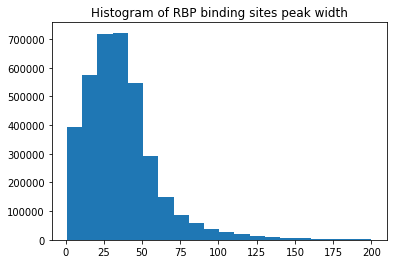

In [9]:
peak_width = RBP_binding_sites["peak_width"].tolist()
plt.hist(peak_width, bins = 20)  # arguments are passed to np.histogram
plt.title("Histogram of RBP binding sites peak width")
plt.show()

### Use "bedtools" in bash under the depository ~/Documents/m6A/Data/metApeakFisher
sort -k1,1 -k2,2n unmerged_peaks_metApeak.bed > peaks.bed

sort -k1,1 -k2,2n unmerged_nonpeaks_metApeak.bed > nonpeaks.bed

bedtools intersect -a ../all.RBP.intersect.hg19.bed -b peaks.bed -s > peak.intersect.RBP.bed

bedtools intersect -a ../all.RBP.intersect.hg19.bed -b nonpeaks.bed -s > nonpeak.intersect.RBP.bed

#### First sort merged peaks, then use the sorted to obtain intersection with RBP directly
sort -k1,1 -k2,2n joint_merged_peaks_counts.bed > peaks.merged.bed

bedtools intersect -a ../all.RBP.intersect.hg19.bed -b peaks.merged.bed -s > peak.merged.intersect.RBP.bed

### Obtain Fisher's exact test statistics

In [10]:
def read_intersect(fn, head = None, cols = ["chr", "chromStart", "chromEnd", "name", "inter_width", "strand"]):
    return pd.read_table(fn, header = head, names = cols)

In [11]:
def get_fisher(peak_fn, nonpeak_fn, peak_merge = False, cols = ['name', 'n_inter_peak', 'n_inter_nonpeak', 
                                                                'n_nointer_peak', 'n_nointer_nonpeak', 
                                                                'fisher_p', 'odds_ratio']):
    peaks_intersect = read_intersect(peak_fn)
    peaks_intersect["peak"] = 1
    nonpeaks_intersect = read_intersect(nonpeak_fn)
    nonpeaks_intersect["peak"] = 0
    intersect = peaks_intersect.append(nonpeaks_intersect)
    fisher_stats = pd.DataFrame(columns = cols)
    idx = 0
    sum_inter_peak = peaks_intersect.shape[0]
    sum_inter_nonpeak = nonpeaks_intersect.shape[0]
    for RBP in list(set(intersect["name"])):
        fisher_stats.loc[idx, 'name'] = RBP
        n_inter_peak = intersect[(intersect["name"] == RBP) & (intersect["peak"] == 1)].shape[0]
        n_inter_nonpeak = intersect[(intersect["name"] == RBP) & (intersect["peak"] == 0)].shape[0]
        n_nointer_peak = sum_inter_peak - n_inter_peak
        n_nointer_nonpeak = sum_inter_nonpeak - n_inter_nonpeak
        fisher_stats.loc[idx, 'n_inter_peak'] = n_inter_peak
        fisher_stats.loc[idx, 'n_inter_nonpeak'] = n_inter_nonpeak
        fisher_stats.loc[idx, 'n_nointer_peak'] = n_nointer_peak
        fisher_stats.loc[idx, 'n_nointer_nonpeak'] = n_nointer_nonpeak
        fisher_stats.loc[idx, 'fisher_p'] = stats.fisher_exact([[n_inter_peak, n_inter_nonpeak], 
                                                                [n_nointer_peak, n_nointer_nonpeak]])[1]
        fisher_stats.loc[idx, 'odds_ratio'] = stats.fisher_exact([[n_inter_peak, n_inter_nonpeak], 
                                                                  [n_nointer_peak, n_nointer_nonpeak]])[0]
        idx += 1
    fisher_stats = fisher_stats.sort_values(by = ["odds_ratio"], ascending = False)
    fisher_stats = fisher_stats.set_index([[i for i in range(fisher_stats.shape[0])]])
    return fisher_stats

In [12]:
fn1 = input_intersect_peak_merged
fn2 = input_intersect_nonpeak
fn3 = input_intersect_peak
fisher_peak_merge = get_fisher(peak_fn = fn1, nonpeak_fn = fn2)
fisher_peak_unmerge = get_fisher(peak_fn = fn3, nonpeak_fn = fn2)

In [16]:
RBP_potential = ["YTHDF", "HNRNP", "FMR1", "IGF2BP", "G3BP"]
RBP_names = fisher_peak_merge["name"].tolist()
RBPs = list()
for RBP in RBP_names:
    tmp = [RBP for item in RBP_potential if RBP.find(item) == 0]
    RBPs.extend(tmp)
print (RBPs)

['IGF2BP3', 'HNRNPUL1', 'HNRNPA1', 'HNRNPM', 'IGF2BP1', 'FMR1', 'HNRNPK', 'HNRNPU', 'IGF2BP2', 'HNRNPC']


#### Fisher test statistics of merged m6A peaks and unmerged nonpeaks

In [17]:
fisher_peak_merge[fisher_peak_merge["name"].isin(RBPs)]

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
3,IGF2BP3,3947,1522,860839,740619,6.24384e-171,2.23113
39,HNRNPUL1,1359,834,863427,741307,1.26388e-14,1.39903
40,HNRNPA1,6224,3837,858562,738304,5.5737e-60,1.39489
43,HNRNPM,5988,3742,858798,738399,1.19999e-53,1.37587
46,IGF2BP1,4282,2848,860504,739293,2.11425e-26,1.29173
48,FMR1,12088,8075,852698,734066,9.05598e-70,1.2887
55,HNRNPK,3247,2228,861539,739913,2.79703e-16,1.25162
56,HNRNPU,5687,3948,859099,738193,5.79733e-25,1.23775
71,IGF2BP2,15260,11806,849526,730335,1.32338e-17,1.11121
99,HNRNPC,46750,44553,818036,697588,1.18857e-59,0.894811


#### Fisher test statistics of unmerged m6A peaks and unmerged nonpeaks

In [18]:
fisher_peak_unmerge[fisher_peak_unmerge["name"].isin(RBPs)]

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
8,IGF2BP3,4586,1522,1148761,740619,2.16158e-122,1.94261
34,FMR1,18832,8075,1134515,734066,1.76903e-217,1.50896
41,IGF2BP1,6264,2848,1147083,739293,1.5377e-55,1.41753
46,IGF2BP2,24619,11806,1128728,730335,9.28274e-160,1.34927
51,HNRNPUL1,1626,834,1151721,741307,7.53018e-08,1.25489
59,HNRNPA1,7037,3837,1146310,738304,8.12827e-17,1.18121
65,HNRNPK,3923,2228,1149424,739913,2.16906e-06,1.13345
73,HNRNPM,6148,3742,1147199,738399,0.00724526,1.0575
78,HNRNPU,6215,3948,1147132,738193,0.527598,1.01303
115,HNRNPC,47454,44553,1105893,697588,0,0.671865


### microRNA

In [93]:
# FIXME: blockSize are not only single start site, but multiple start sites
miRNA = pd.read_table(input_miRNA, header = 0, usecols = [0,1,2,3,5,10,12])
miRNA["name_gene"] = miRNA.apply(lambda row: row["name"].split(":")[0], axis = 1)
Counter(miRNA["blockSize"].tolist())

Counter({'1,6': 7,
         '1,7': 1,
         '2,5': 6,
         '2,6': 5,
         '3,4': 5,
         '3,5': 5,
         '4,3': 5,
         '4,4': 1,
         '5,2': 4,
         '5,3': 3,
         '6,1': 10,
         '6,2': 2,
         '7': 19242,
         '7,1': 2,
         '8': 9695})

In [94]:
miRNA.sort_values(by = ["miRNA", "chr", "start"]).head(10)

,chr,start,end,name,strand,blockSize,miRNA,name_gene
332,chr1,23241151,23241159,EPHB2:miR-1249-3p,+,8,hsa-miR-1249-3p,EPHB2
557,chr1,32262242,32262250,SPOCD1:miR-1249-3p,-,8,hsa-miR-1249-3p,SPOCD1
2742,chr1,210416343,210416350,SERTAD4:miR-1249-3p,+,7,hsa-miR-1249-3p,SERTAD4
7345,chr12,109702176,109702183,ACACB:miR-1249-3p,+,7,hsa-miR-1249-3p,ACACB
8952,chr14,77942134,77942141,ISM2:miR-1249-3p,-,7,hsa-miR-1249-3p,ISM2
9855,chr15,68126794,68126802,SKOR1:miR-1249-3p,+,8,hsa-miR-1249-3p,SKOR1
12164,chr17,46689743,46689750,HOXB8:miR-1249-3p,-,7,hsa-miR-1249-3p,HOXB8
14077,chr19,54634830,54634838,PRPF31:miR-1249-3p,+,8,hsa-miR-1249-3p,PRPF31
14414,chr2,31489189,31489196,EHD3:miR-1249-3p,+,7,hsa-miR-1249-3p,EHD3
17636,chr22,31302263,31302270,OSBP2:miR-1249-3p,+,7,hsa-miR-1249-3p,OSBP2


In [95]:
cols_miRNA = ["chr", "start", "end", "miRNA", "blockSize", "strand"]
cols_sortby = ["miRNA", "chr", "start"]
miRNA[cols_miRNA].sort_values(by = cols_sortby).to_csv(output_miRNA, index = False, header = False, sep = "\t")

### Use bedtools to obtain intersect of peak/nonpeak with miRNA
bedtools intersect -a ../miRNA.bed -b peaks.bed -s > peak.intersect.miRNA.bed

bedtools intersect -a ../miRNA.bed -b peaks.merged.bed -s > peak.merged.intersect.miRNA.bed

bedtools intersect -a ../miRNA.bed -b nonpeaks.bed -s > nonpeak.intersect.miRNA.bed

In [96]:
fn4 = input_intersect_peak_miRNA
fn5 = input_intersect_nonpeak_miRNA
fn6 = input_intersect_peak_merged_miRNA
fisher_peak_merge_miRNA = get_fisher(peak_fn = fn4, nonpeak_fn = fn5)
fisher_peak_unmerge_miRNA = get_fisher(peak_fn = fn6, nonpeak_fn = fn5)

In [97]:
fisher_peak_merge_miRNA.sort_values(by = ["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-423-3p,14,2,4097,5570,0.000411393,9.51672
1,hsa-miR-615-3p,6,1,4105,5571,0.0468939,8.14275
2,hsa-miR-210-3p,12,3,4099,5569,0.00652779,5.4345
3,hsa-miR-127-3p,8,2,4103,5570,0.0224176,5.43017
4,hsa-miR-1249-3p,7,2,4104,5570,0.0423882,4.75024
5,hsa-miR-423-5p,58,37,4053,5535,0.000338675,2.14076
6,hsa-miR-212-5p,115,77,3996,5495,1.29815e-06,2.05376
7,hsa-miR-296-5p,63,43,4048,5529,0.000491663,2.00114
8,hsa-miR-328-3p,53,38,4058,5534,0.00269857,1.90204
9,hsa-miR-331-3p,52,40,4059,5532,0.00775151,1.77177


In [98]:
fisher_peak_unmerge_miRNA.sort_values(by = ["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-423-3p,12,2,3730,5570,0.000633014,8.95979
1,hsa-miR-615-3p,6,1,3736,5571,0.0192638,8.947
2,hsa-miR-127-3p,8,2,3734,5570,0.0184861,5.96679
3,hsa-miR-210-3p,9,3,3733,5569,0.0178034,4.47549
4,hsa-miR-1249-3p,6,2,3736,5570,0.0672055,4.4727
5,hsa-miR-212-5p,104,77,3638,5495,2.47405e-06,2.04008
6,hsa-miR-423-5p,50,37,3692,5535,0.00131384,2.02593
7,hsa-miR-296-5p,56,43,3686,5529,0.00127732,1.95349
8,hsa-miR-328-3p,47,38,3695,5534,0.00525086,1.85242
9,hsa-miR-331-3p,48,40,3694,5532,0.00835722,1.79708
